In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets

Create our values for C (class) which are 2 xy pairs that define a rectangle for which all positive examples are inside and all negitive examples are outside

In [2]:
# NEED WORK


def find_new_general_y(mask_min_y, mask_max_y, min_x_neg, max_x_neg, sorted_y):
    min_y_ind, max_y_ind = -1,0
    found_edge = False 
    while not found_edge:
        try:
            if min_x_neg[0]<sorted_y[mask_min_y][min_y_ind][0]<max_x_neg[0]:
                found_min_y = sorted_y[mask_min_y][min_y_ind]
                found_edge = True
            else: 
                min_y_ind -= 1
        except:
            #print("Couldn't find new y's")
            found_edge = True
            found_min_y = sorted_y[mask_min_y][-1]
            
    found_edge = False 
    while not found_edge:
        try:
            if min_x_neg[0]<sorted_y[mask_max_y][max_y_ind][0]<max_x_neg[0]:
                found_max_y = sorted_y[mask_max_y][max_y_ind]
                found_edge = True
            else: 
                max_y_ind += 1
        except:
            #print("Couldn't find new y's")
            found_edge = True
            found_max_y = sorted_y[mask_max_y][0]
    return found_min_y, found_max_y



def find_new_general_x(mask_min_x, mask_max_x, min_y_neg, max_y_neg, sorted_x):
    min_x_ind, max_x_ind = -1,0
    found_edge = False
    while not found_edge:
        if min_y_neg[1]<sorted_x[mask_min_x][min_x_ind][1]<max_y_neg[1]:
            found_min_x = sorted_x[mask_min_x][min_x_ind]
            found_edge = True
        else: 
            min_x_ind -= 1
            
    found_edge = False 
    while not found_edge: 
        if min_y_neg[1]<sorted_x[mask_max_x][max_x_ind][1]<max_y_neg[1]:
            found_max_x = sorted_x[mask_max_x][max_x_ind]
            found_edge = True
        else: 
            max_x_ind += 1
    return found_min_x, found_max_x

In [3]:
def create_rectange(min_x, min_y, max_x, max_y, color):
    return patches.Rectangle((min_x,min_y),max_x-min_x,max_y-min_y,linewidth=2,edgecolor=color,facecolor='none')

def cal_rect_area(rect):
    rect_w = rect[1][0] - rect[0][0]
    rect_h = rect[1][1] - rect[0][1]
    return rect_w*rect_h

def calc_vector_space(general, specific):
    #Area of our general rectangle - Area of our Specific rectange
    general_area = cal_rect_area(general)
    specific_area = cal_rect_area(specific)
    
    return general_area-specific_area

def calculate_hypothesis_postivity(hypothesis, ground_truth):
    #First calculate the intersection area.
    #Find the bottom left point of the intersection (Max of the x min)
    x1 = max(hypothesis[0][0], ground_truth[0][0])
    y1 = max(hypothesis[0][1], ground_truth[0][1])

    x2 = min(hypothesis[1][0], ground_truth[1][0])
    y2 = min(hypothesis[1][1], ground_truth[1][1])
    
    intersection_area = (x2-x1)*(y2-y1)
    #Find the Union area 
    hypothesis_area = cal_rect_area(hypothesis)
    ground_truth_area = cal_rect_area(ground_truth)
    union_area = hypothesis_area + ground_truth_area - intersection_area
    
    accuracy = intersection_area/union_area
    false_negative = (ground_truth_area - intersection_area)/ground_truth_area
    false_positive = (hypothesis_area - intersection_area)/intersection_area
    
    return accuracy, false_negative, false_positive

    

(0.7295929919956788,
 0.18063737626582876,
 0.15016635548215354,
 2.6495682770640587)

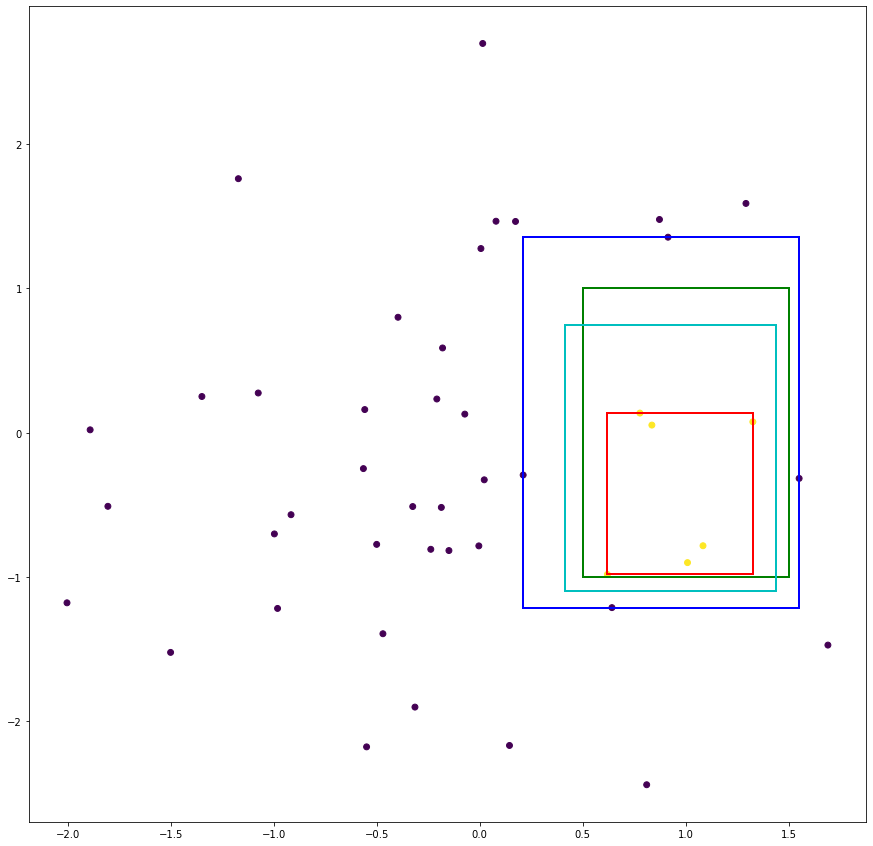

In [4]:
def create_vanpnik_dims(x_min, y_min, x_max, y_max, seed, num_points, plot_points=True):
    
    #Create our empty array for our scatter plot and set random seed
    a = np.zeros(shape=(num_points,3))
    rng = np.random.RandomState(seed)
    
    #Create our C values evething in this rectangle is true everything outside is false
    p1 = np.array([x_min , y_min])
    p2 =  np.array([x_max , y_max])
    ground_truth = [[x_min , y_min], [x_max , y_max]]

    #Create our Scatter plot
    a[:,0] = rng.randn(num_points)
    a[:,1] = rng.randn(num_points)
    #Set all values inside C rectangle to true, everything else to false
    a[:,2] = [True if p2[0]>x[0]>p1[0] and p2[1]>x[1]>p1[1] else False for x in a[:,0:2] ]
    try:
        #Calculate our Specific Hypothisis defined by the smallest rectangle we can draw that contains all Positive examples and no negative examples
        mask = a[:,2] == 1
        positive = a[mask,:]

        max_x_pos = np.amax(positive[:,0])
        max_y_pos = np.amax(positive[:,1])
    
        min_x_pos = np.amin(positive[:,0])
        min_y_pos = np.amin(positive[:,1])
    
        #Contains the edges of our specific hypothosis
        specific = [[min_x_pos, min_y_pos], [max_x_pos, max_y_pos]]
        specific_hypothesis_rect = create_rectange(specific[0][0], specific[0][1], specific[1][0], specific[1][1], 'r')

        #Calculate our General Hypothisis defined by the Largest rectangle we can draw that contains all Postivie examples and no negative examples
        sorted_x =  a[a[:, 0].argsort()]
        mask_min_x = sorted_x[:,0] < min_x_pos
        mask_max_x = sorted_x[:,0] > max_x_pos
        min_x_neg = sorted_x[mask_min_x][-1]
        max_x_neg = sorted_x[mask_max_x][0]

        sorted_y =  a[a[:, 1].argsort()]
        mask_min_y = sorted_y[:,1] < min_y_pos
        mask_max_y = sorted_y[:,1] > max_y_pos

        found_min_y, found_max_y = find_new_general_y(mask_min_y, mask_max_y, min_x_neg, max_x_neg, sorted_y)
        found_min_x, found_max_x = find_new_general_x(mask_min_x, mask_max_x, found_min_y, found_max_y, sorted_x)

        found_min_y, found_max_y = find_new_general_y(mask_min_y, mask_max_y, found_min_x, found_max_x, sorted_y)
        found_min_x, found_max_x = find_new_general_x(mask_min_x, mask_max_x, found_min_y, found_max_y, sorted_x)
        found_min_y, found_max_y = find_new_general_y(mask_min_y, mask_max_y, found_min_x, found_max_x, sorted_y)
    
        #Contains the edges of our general hypothosis
        general = [[found_min_x[0], found_min_y[1]], [found_max_x[0], found_max_y[1]]]
        general_hypothesis_rect = create_rectange(general[0][0], general[0][1], general[1][0], general[1][1], 'b')

        #Calculate our Hpyothisis which is the difference between the Genearal and Specific Hypothosis 
        min_x_hy = (min_x_pos - general[0][0])/2 + general[0][0]
        min_y_hy = (min_y_pos - general[0][1])/2 + general[0][1]

        max_x_hy = (max_x_pos - general[1][0])/2 + general[1][0]
        max_y_hy = (max_y_pos - general[1][1])/2 + general[1][1]

        hypothesis = [[min_x_hy, min_y_hy], [max_x_hy, max_y_hy]]
        hypothesis_rect = create_rectange(min_x_hy, min_y_hy, max_x_hy, max_y_hy, 'c')
    
        #Calculate properties of our hypothosis
        #Vector space (Area between our specific and general)
        vector_space = calc_vector_space(general, specific)
        accuracy, false_negative, false_positive = calculate_hypothesis_postivity(hypothesis, ground_truth)
        
        if plot_points:  
            fig = plt.figure(figsize=(15,15)) 
            class_box = create_rectange(p1[0], p1[1], p2[0], p2[1], 'g')

            ax = fig.add_subplot(111) 
            ax.scatter(a[:,0], a[:,1], c=a[:,2], s=35)

            ax.add_patch(class_box)
            ax.add_patch(specific_hypothesis_rect)
            ax.add_patch(general_hypothesis_rect)
            ax.add_patch(hypothesis_rect)
    except: 
        print("Not enough data for General Hypothesis")
        accuracy, false_negative, false_positive, vector_space = 0, 1, 1, 2
        
    return accuracy, false_negative, false_positive, vector_space
    
    
create_vanpnik_dims(.5, -1, 1.5, 1, 14, 45)

In [5]:


x_min_slide = widgets.FloatSlider(
         description='x_min:',
         value=0,
         min=-3,
         max=3,
         step=0.1,)
y_min_slide = widgets.FloatSlider(
         description='y_min:',
         value=0,
         min=-3,
         max=3,
         step=0.1,)

x_max_slide = widgets.FloatSlider(
         description='x_max:',
         value=1,
         min=-3,
         max=3,
         step=0.1,)

y_max_slide = widgets.FloatSlider(
         description='y_max:',
         value=1,
         min=-3,
         max=3,
         step=0.1,)


random_state_slide = widgets.IntSlider(
         description='Seed:',
         value=1,
         min=0,
         max=100,
         step=1,)


num_points_slide = widgets.IntSlider(
         description='num points:',
         value=40,
         min=4,
         max=200,
         step=1,)

n_start = widgets.IntSlider(
         description='start:',
         value=40,
         min=4,
         max=200,
         step=1,)

n_end = widgets.IntSlider(
         description='end:',
         value=40,
         min=4,
         max=1000,
         step=1,)


menu = widgets.Dropdown(
       options=['red', 'blue', 'green'],
       value='red',
       description='Color:')

In [6]:
box = widgets.VBox([x_min_slide, y_min_slide, x_max_slide, y_max_slide, random_state_slide, num_points_slide])
box

(0.9371058581215624,
 0.014774573898345689,
 0.05211916574212143,
 1.771072472855258)

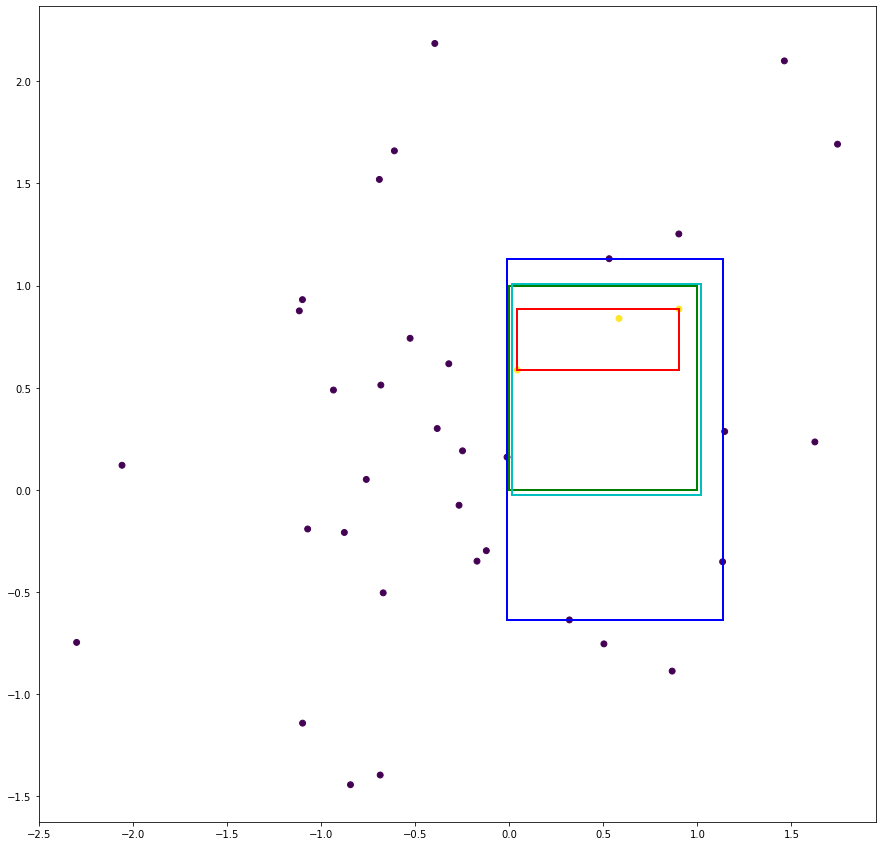

In [11]:
create_vanpnik_dims(x_min_slide.value, y_min_slide.value, x_max_slide.value , y_max_slide.value, random_state_slide.value, num_points_slide.value)

In [1]:
accuracy_box = widgets.VBox([x_min_slide, y_min_slide, x_max_slide, y_max_slide, random_state_slide, n_start, n_end])
accuracy_box

NameError: name 'widgets' is not defined

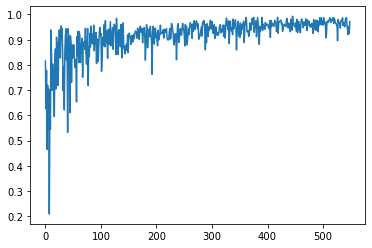

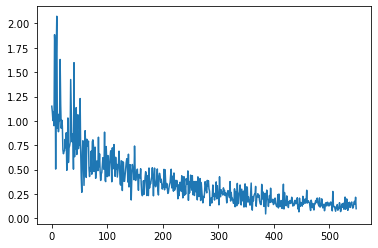

In [158]:
df = pd.DataFrame(columns = ["acc", "false_neg", "false_pos", "vector_space"])
for n in range(n_start.value, n_end.value):
    accuracy, false_negative, false_positive, vector_space = create_vanpnik_dims(x_min_slide.value, y_min_slide.value, x_max_slide.value , y_max_slide.value, random_state_slide.value, n, plot_points=False)
    df=df.append({'acc': accuracy, 'false_neg': false_negative, 'false_pos': false_positive, "vector_space": vector_space}, ignore_index=True)


plt.plot(df['acc'])
#plt.plot(df['false_neg'])
#plt.plot(df['false_pos'])
plt.show()
plt.plot(df['vector_space'])
plt.show()